## Introduction
Once every few days, Instacart sends out an offer to users of the mobile app. An offer can be merely an advertisement for a specific grocery item or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.
Not all users received the same offer, 
We have combined transactions, demographics and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the Instacart app because we will be analyzing one product whereas Instacart sells millions of products.
Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.
We will be looking at transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.


### Example
(*Something to keep in mind, is that some of these users may be making a purchase through the app without having received an offer or without seeing their offer)
To give an example of the types of promitions, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.
However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Who is our Customer

After the customer segmentation process we have a better understanding of who our customer is and their demographic and spending habits. Understanding our customers is the key providing them a good service and sustain a profitable business. 

In this study we will see if we were able to engage those demographics through various initiatives and incentives. Periodically, Instacart sends out an offer to users of the mobile app. 

Part 1 & Part 2
1. Gain understanding what types of customer characteristics and demographics are there.
2. What offer should be sent to each customer based on their demograhics ?

Part 3
3. How well can we predict customer response to the offer ?

### Project Metrics :
Unsupervised Machine Learning Model
An unsupervised machine learning model with K-Means is used to cluster the customers.
The number of clusters is chosen with 2 metrics :
1. The Silhouttee score) The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.  
2. The Inertia / Sum Square Error (SSE) value, can be recognized as a measure of how internally coherent clusters are. We seek to minimize the value. 
Supervised Machine Learning Model
A Supervised Machine learning using regression algorithm is used to predict customers offer completed rate. The regression metrics are :
1. Mean Squared Error (MSE):
2. Coefficient of Determination (R^2)

### Data Sets¶
##### The data is contained in three files:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.csv - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed
##### Here is the schema and explanation of each variable in the files:
###### portfolio.json
* id (string) - membership  id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) -
* channels (list of strings)
###### profile.csv
* age (int) - age of the customer
* gender (str) - gender of the customer (Male, Female)
* id (str) - membership  id
* income (float) - customer's income
* user_id(int)- customer user id used throughout the Instacart datasets
###### transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - (same as membership  id)
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [2]:
# read in the files
portfolio = pd.read_json('portfolio.json',orient='records', lines=True )
profile = pd.read_csv('data/clean_profile.csv')
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,user_id,gender,age,id,income
0,1,Male,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0
1,3,Male,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,5,Female,68.0,e2127556f4f64592b11af22de27a7932,70000.0
3,8,Female,65.0,389bc3fa690240e798340f5a15918d5c,53000.0
4,12,Female,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
print(profile.describe())

            user_id           age         income
count  14825.000000  14825.000000   14825.000000
mean    8496.961079     48.949515   65404.991568
std     4896.261043     16.308582   21598.299410
min        1.000000     18.000000   30000.000000
25%     4273.000000     35.000000   49000.000000
50%     8490.000000     52.000000   64000.000000
75%    12733.000000     62.000000   80000.000000
max    16999.000000     77.000000  120000.000000


In [7]:
print(profile['gender'].unique())

['Male' 'Female']


In [8]:
transcript.query('event == "transaction"').head(1)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0


In [9]:
transcript.query('event == "offer received"').head(1)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [10]:
transcript.query('event == "offer viewed"').head(1)

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [11]:
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [12]:
print('Unique event types:')
print(transcript['event'].unique())

print('\nDescriptive stats for time:')
print(transcript.describe())

Unique event types:
['offer received' 'offer viewed' 'transaction' 'offer completed']

Descriptive stats for time:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


In [13]:
# Impute Income
profile['income_na'] = profile['income'].isna().astype(int)
profile['income'] = profile['income'].fillna(profile['income'].mean())

## One Hot Encoding

In [14]:
# channel dummies
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [15]:
# gender type dummies
gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')
profile = pd.concat([profile, gender_dummies], axis=1)

profile.head()

,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,1,Male,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1
1,3,Male,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1
2,5,Female,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
3,8,Female,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
4,12,Female,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
# event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

#profile.drop(['event'], axis=1, inplace=True)

transcript.head()

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0


### Split Offer and Transaction Data Frames

In [18]:
transcript.dtypes

person             object
event              object
value              object
time                int64
offer_completed     int64
offer_received      int64
offer_viewed        int64
dtype: object

In [19]:
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)

### Merge Data Frames

In [20]:
# Check each header row
transcript.head(1)

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0


In [21]:
portfolio.head(1)

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0


In [22]:
profile.head(1)

,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,1,Male,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1


In [23]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
offers.drop(['id_x', 'id_y'], axis=1, inplace=True)
offers.set_index('offer_id', inplace=True)
offers.head(2)

,person,event,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,income,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,3,Male,75.0,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,3,Male,75.0,100000.0,...,5,7,bogo,1,1,0,1,1,0,0


In [24]:
transactions = transactions.merge(profile, left_on='person', right_on='id')
transactions.drop(['event'], axis=1, inplace=True)
transactions.head(2)

,person,time,amount,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,41,Male,20.0,02c083884c7d45b39cc68e1314fec56c,30000.0,0,0,1
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,41,Male,20.0,02c083884c7d45b39cc68e1314fec56c,30000.0,0,0,1


### Drop Outliers

In [25]:
transactions.describe()

,time,amount,user_id,age,income,income_na,gender_Female,gender_Male
count,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000,123957.0,123957.000000,123957.000000
mean,381.278201,13.996325,8502.048049,47.658011,61843.510250,0.0,0.601620,0.398380
std,201.829085,31.749420,4893.376236,16.501572,20661.890394,0.0,0.489566,0.489566
min,0.000000,0.050000,1.000000,18.000000,30000.000000,0.0,0.000000,0.000000
25%,210.000000,3.660000,4290.000000,33.000000,46000.000000,0.0,0.000000,0.000000
50%,402.000000,10.800000,8505.000000,50.000000,60000.000000,0.0,1.000000,0.000000
75%,552.000000,19.130000,12716.000000,61.000000,74000.000000,0.0,1.000000,1.000000
max,714.000000,1062.280000,16999.000000,77.000000,120000.000000,0.0,1.000000,1.000000


In [26]:
# is the max age at 77 ok?
#if not create a different cleaned profile set to use

### Repeat Offer Exposure

In [27]:
# the same offer can be received and viewed multiple times
#do we need this
#offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head()

In [28]:
offers.reset_index(inplace=True)

In [29]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head()

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,3,Male,75.0,...,5,7,bogo,1,1,0,1,1,0,0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,3,Male,75.0,...,5,7,bogo,1,1,0,1,1,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,3,Male,75.0,...,5,7,bogo,1,1,0,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408,0,1,0,5,Female,68.0,...,5,7,bogo,1,1,0,1,1,0,0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420,0,0,1,5,Female,68.0,...,5,7,bogo,1,1,0,1,1,0,0


In [30]:
# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']
offers.head()

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,0,1,0,3,Male,75.0,...,1,1,0,1,1,0,0,0.5,0.0,0.0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.5,0,0,1,3,Male,75.0,...,1,1,0,1,1,0,0,0.0,6.5,0.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.5,1,0,0,3,Male,75.0,...,1,1,0,1,1,0,0,0.0,0.0,132.5
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408.5,0,1,0,5,Female,68.0,...,1,1,0,1,1,0,0,408.5,0.0,0.0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420.5,0,0,1,5,Female,68.0,...,1,1,0,1,1,0,0,0.0,420.5,0.0


In [31]:
# an offer can be received multiple times by the same person
# we'll use first exposure times, but keep track of the number of exposures

offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sums = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

offers_mins.update(offers_sums)

offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()

offers_grouped.fillna(0, inplace=True)

offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,income,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,3793,Female,33.0,72000.0,...,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,3793,Female,33.0,72000.0,...,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,3793,Female,33.0,72000.0,...,1,1,1,0,0,0,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,3793,Female,33.0,72000.0,...,1,1,1,1,1,0,0,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,3793,Female,33.0,72000.0,...,1,1,1,1,0,1,0,504.5,540.5,528.5


### Drop Missatributions

In [32]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration'] * 24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis=1)

# dropping misattributions (completion without view, completion before view, or view before receipt)
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

### Regency and Frequency

In [33]:
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)

profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

customers = profile.join(rf)
customers.head()

,user_id,gender,age,income,income_na,gender_Female,gender_Male,frequency,recency,monetary_value
person,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,Male,55.0,112000.0,0,0,1,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,3,Male,75.0,100000.0,0,0,1,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,5,Female,68.0,70000.0,0,1,0,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,8,Female,65.0,53000.0,0,1,0,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,12,Female,58.0,51000.0,0,1,0,3.0,15.0,4.433333


### Conversion Rates

In [34]:
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean() 

# BOGO offers
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# discount offers
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

,user_id,gender,age,income,income_na,gender_Female,gender_Male,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,total_cr
person,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,Male,55.0,112000.0,0,0,1,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,3,Male,75.0,100000.0,0,0,1,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,1.000000
e2127556f4f64592b11af22de27a7932,5,Female,68.0,70000.0,0,1,0,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.666667
389bc3fa690240e798340f5a15918d5c,8,Female,65.0,53000.0,0,1,0,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,12,Female,58.0,51000.0,0,1,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.500000


### Customer Offers

In [35]:
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean'),
)

customers = customers.join(customer_offers)

customers.drop(['gender'], axis=1, inplace=True)
customers.dropna(inplace=True)

customers.head()

,user_id,age,income,income_na,gender_Female,gender_Male,frequency,recency,monetary_value,bogo_vr,...,web_cnt,bogo_cnt,discount_cnt,informational_cnt,offers_received_cnt,offers_viewed_cnt,offers_completed_cnt,exposures_received_avg,exposures_viewed_avg,exposures_completed_avg
person,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,55.0,112000.0,0,0,1,2.0,21.0,27.750000,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000
78afa995795e4d85b5d9ceeca43f5fef,3,75.0,100000.0,0,0,1,5.0,16.0,24.320000,1.0,...,1.0,2.0,0.0,1.0,3.0,3.0,2.0,1.0,1.000000,0.666667
e2127556f4f64592b11af22de27a7932,5,68.0,70000.0,0,1,0,1.0,10.0,18.420000,1.0,...,4.0,1.0,2.0,1.0,4.0,3.0,2.0,1.0,0.750000,0.500000
389bc3fa690240e798340f5a15918d5c,8,65.0,53000.0,0,1,0,2.0,22.0,13.445000,1.0,...,4.0,2.0,2.0,0.0,4.0,4.0,4.0,1.5,1.500000,1.250000
2eeac8d8feae4a8cad5a6af0499a211d,12,58.0,51000.0,0,1,0,3.0,15.0,4.433333,0.0,...,3.0,0.0,2.0,1.0,3.0,2.0,1.0,1.0,0.666667,0.333333


### will redo with Json and Better cleaned profile

## VISUALIZING DATA

In [36]:
# create Instacart color scheme with adobe scan
instacart = ["#5CA43A", "#FF4D00", "#85BD69", "#E7AD75"]
instacart_d = ["#00DDD2", "#8BF3B0", "#B5F7A6","#00C0B0"]
genders = ["#6880f8", "#C668B8"]

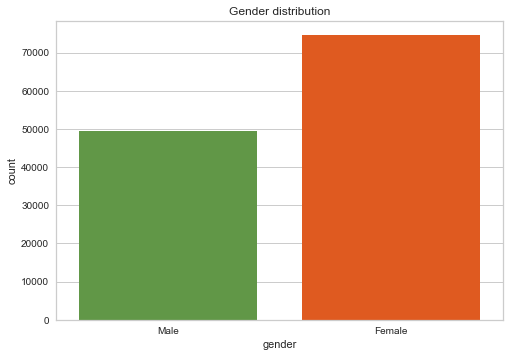

In [37]:
sns.set_palette(sns.color_palette(instacart))

df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

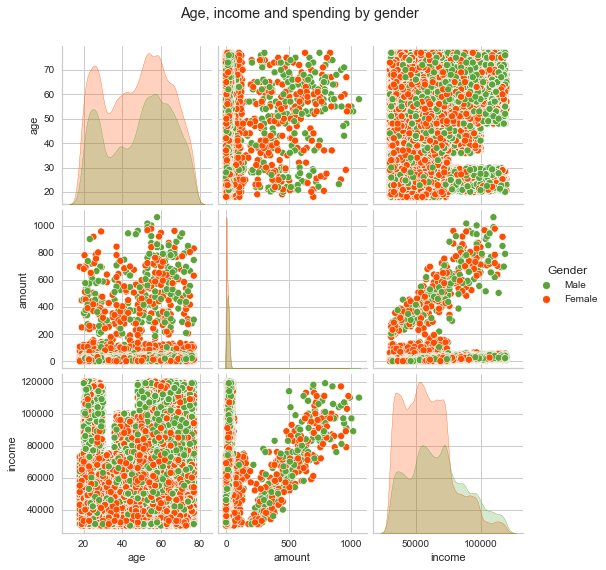

In [38]:
sns.set_palette(sns.color_palette(instacart))

df = transactions[['gender', 'age', 'amount', 'income']].query('gender in ["Female", "Male"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'Male': 'Male', 'Female': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

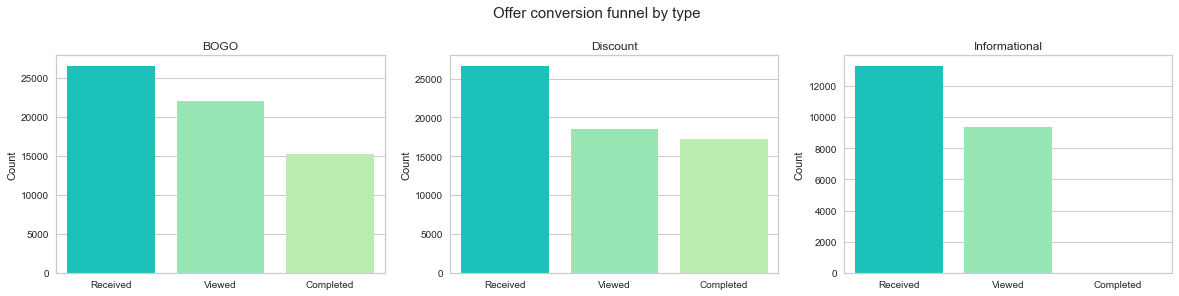

In [39]:
sns.set_palette(sns.color_palette(instacart))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=instacart_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=instacart_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=instacart_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

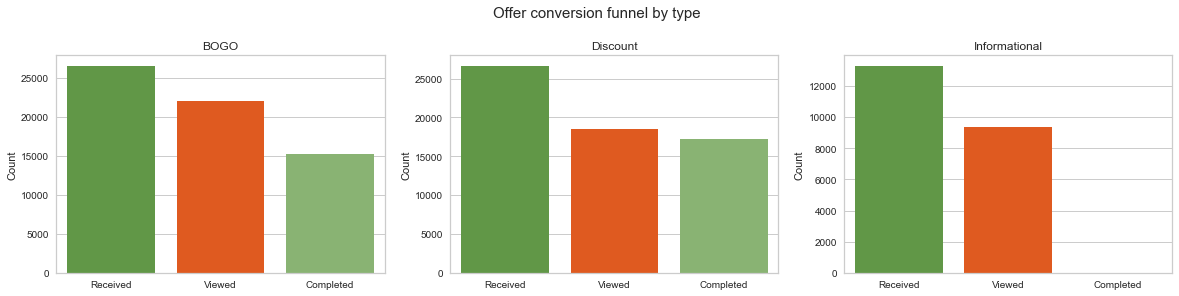

In [40]:
#Try with second pallette 
sns.set_palette(sns.color_palette(instacart))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=instacart, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=instacart, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=instacart, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

## Modeling

In [41]:
# scale
scaler = StandardScaler().fit(customers)
customers_scaled = scaler.transform(customers)
customers_scaled.std(axis=0)[:5], customers_scaled.mean(axis=0)[:5]

(array([1., 1., 1., 0., 1.]),
 array([ 2.46826705e-16, -4.36767568e-16, -8.14720960e-17,  0.00000000e+00,
         2.50683372e-17]))

In [42]:
# Reduce Dimensionality
pca = PCA()
X_pca = pca.fit_transform(customers_scaled)

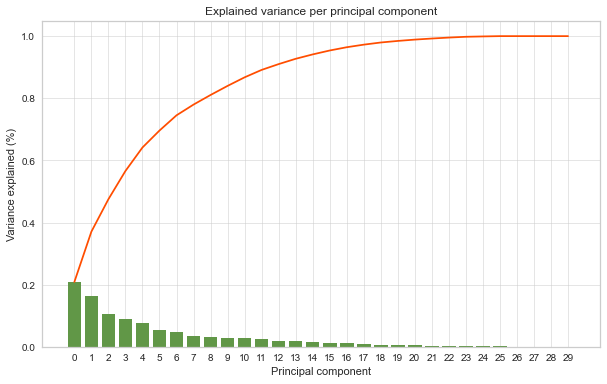

In [44]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=instacart[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=instacart[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained (%)")
plt.title('Explained variance per principal component');

In [45]:
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])

# rerun PCA with components that explain 80% of the variance
pca = PCA(num_components).fit(customers_scaled)
X_pca = pca.transform(customers_scaled)
X_pca = pd.DataFrame(X_pca)

np.cumsum(pca.explained_variance_ratio_)

array([0.20872129, 0.3706204 , 0.47501815, 0.56589492, 0.64145729,
       0.69600266, 0.745056  , 0.77962426])

## Clustering 

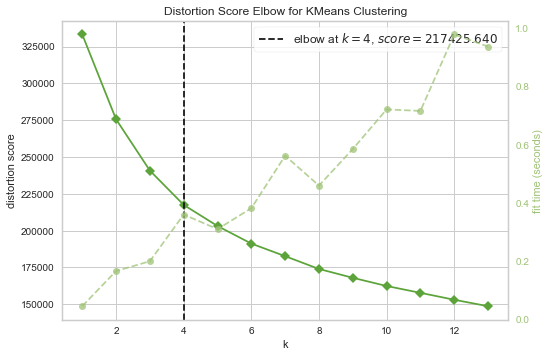

In [46]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,14));

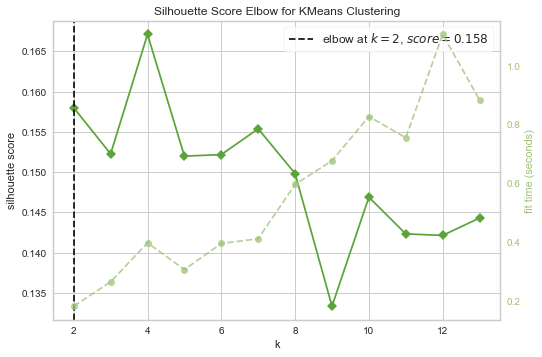

In [47]:
# silhouette method
kelbow_visualizer(KMeans(), X_pca, k=(2,14), metric='silhouette');

In [48]:
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

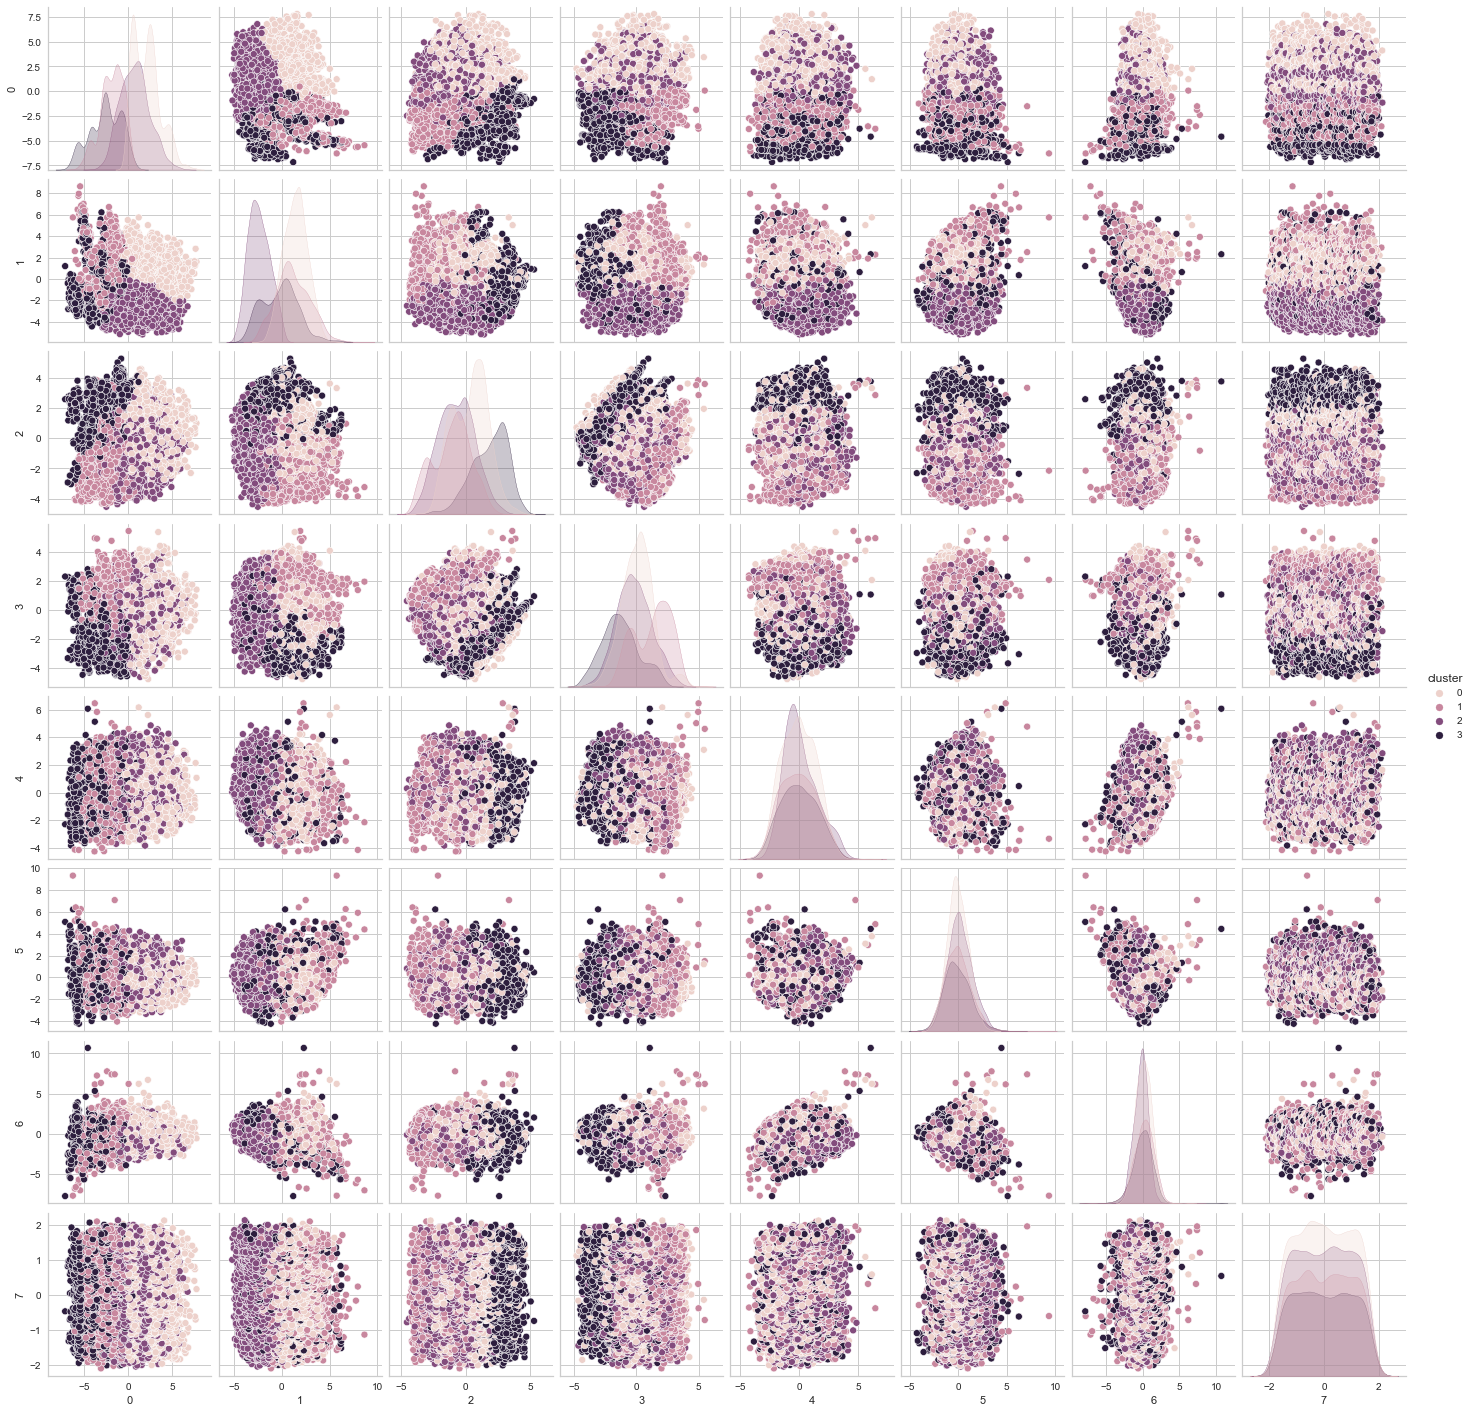

In [49]:
df = X_pca.copy()
df['cluster'] = kmeans_clusters
sns.pairplot(df, hue='cluster')

## Evaluation